In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DkBHMOozWtubE225J8lf2gIy0Qc0tv85' -O meta
!unzip meta
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1j3C-IEqyRxXIJnKmvehU7F3R0QxOGYfl' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\n/p')&id=1j3C-IEqyRxXIJnKmvehU7F3R0QxOGYfl" -O data && rm -rf /tmp/cookies.txt
!unzip data

--2023-11-06 15:30:43--  https://docs.google.com/uc?export=download&id=1DkBHMOozWtubE225J8lf2gIy0Qc0tv85
Resolving docs.google.com (docs.google.com)... 74.125.20.100, 74.125.20.101, 74.125.20.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cacnfegg5ivinmv4r6t7d34o0cdk68f7/1699284600000/08006872813910256829/*/1DkBHMOozWtubE225J8lf2gIy0Qc0tv85?e=download&uuid=a6546fe6-d4d6-4e48-b07a-caaec5aed037 [following]
--2023-11-06 15:30:43--  https://doc-0g-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cacnfegg5ivinmv4r6t7d34o0cdk68f7/1699284600000/08006872813910256829/*/1DkBHMOozWtubE225J8lf2gIy0Qc0tv85?e=download&uuid=a6546fe6-d4d6-4e48-b07a-caaec5aed037
Resolving doc-0g-20-docs.googleusercontent.com (doc-0g-20-docs.googleusercontent.com)... 142.250.99.132, 2607:f8b0:400e

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import torch

In [3]:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    device="cuda"
    print("Use CUDA")
else:
    device="cpu"

Use CUDA


In [4]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
ADD_PATH = './cars_train/cars_train'

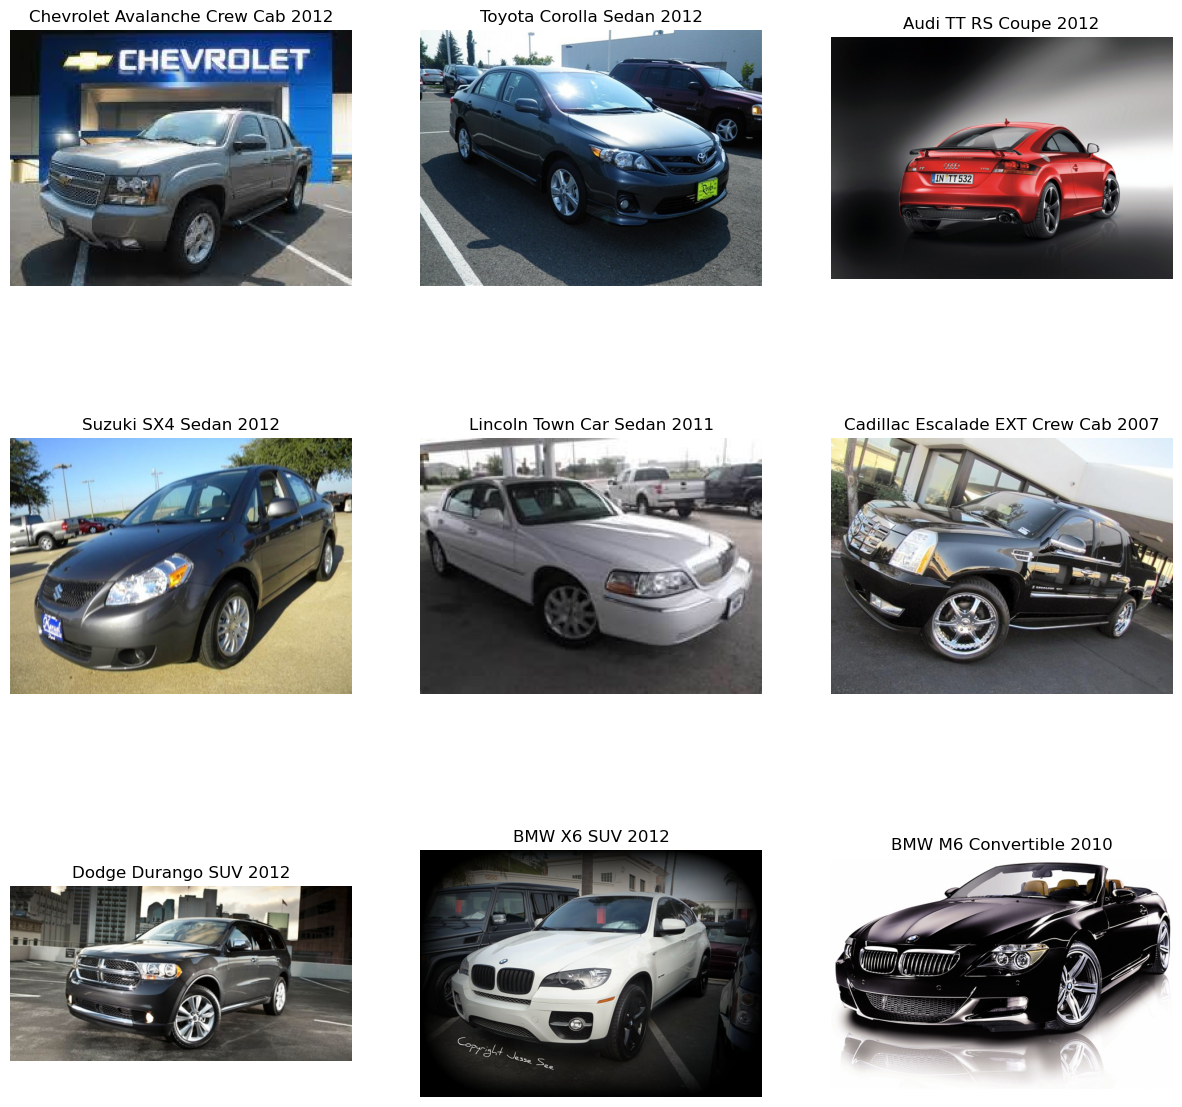

In [6]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

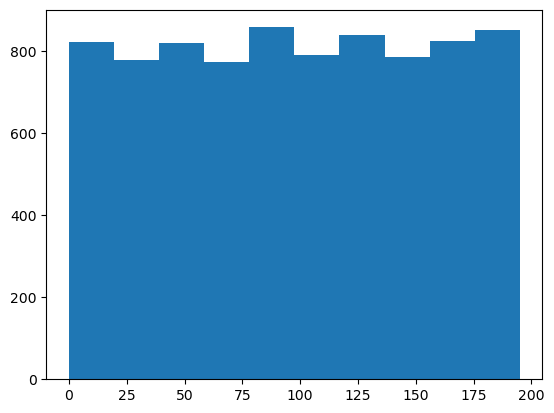

In [9]:
plt.hist(fname_to_class.values())
plt.show()

In [10]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [21]:


train_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            torchvision.transforms.RandomApply(torchvision.transforms.RandomVerticalFlip(), p=0.5),
            torchvision.transforms.RandomApply(torchvision.transforms.RandomRotation(15), p=0.5),
            torchvision.transforms.RandomApply(torchvision.transforms.GaussianBlur(kernel_size=(51, 51)), p=0.5),
            torchvision.transforms.RandomApply(torchvision.transforms.RandomGrayscale(), p=0.5),
            ])


In [22]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_trasfrom)
val_dataset = CropClassifDataset(val_items, val_transforms)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

In [14]:
!pip install lightning pytorch_metric_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00


In [24]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from torchvision.models import alexnet
from pytorch_metric_learning import miners, losses

class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = alexnet(pretrained=True)

        self.model.classifier = torch.nn.Sequential(
                            torch.nn.Linear(in_features = 256*6*6, out_features=emb_size))
        self.classifier_head = torch.nn.Sequential(
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=emb_size, out_features=len(class_dict)))
        self.triplet_miner = miners.TripletMarginMiner(type_of_triplets="semihard")
        self.triplet_loss = losses.TripletMarginLoss()
        self.alpha = 0.4

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)

        hard_pairs = self.triplet_miner(preds, labels)
        final_loss = self.triplet_loss(preds, labels, hard_pairs)

        self.log("train_loss", final_loss, sync_dist=True)
        return final_loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)

        hard_pairs = self.triplet_miner(preds, labels)
        final_loss = self.triplet_loss(preds, labels, hard_pairs)

        self.log("validation_loss", final_loss, sync_dist=True)

    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images)
        else:
            preds = self.model(images.unsqueeze(0))
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [25]:
device

'cuda'

In [26]:
# model
pl_model = CarEmbedder(id_to_car, 3e-4, 512)
checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min', save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 10, accelerator=device, devices = 1, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(model=pl_model, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type               | Params
-------------------------------------------------------
0 | model           | AlexNet            | 7.2 M 
1 | classifier_head | Sequential         | 100 K 
2 | triplet_miner   | TripletMarginMiner | 0     
3 | triplet_loss    | TripletMarginLoss  | 0     
-------------------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.157    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [28]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    0.02553965523838997    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.02553965523838997}]

In [39]:
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https: //ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
deb https: //ngrok-agent.s3.amazonaws.com buster main
Ign:1 https: //ngrok-agent.s3.amazonaws.com InRelease
Err:2 https: //ngrok-agent.s3.amazonaws.com Release                            
  Undetermined Error
Get:3 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1299 B]    
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                         
E: Repository 'http://packages.cloud.google.com/apt gcsfuse-focal InRelease' changed its 'Origin' value from 'gcsfuse-jessie' to 'namespaces/gcs-fuse-prod/repositories/gcsfuse-focal'
E: Repository 'http://packages.cloud.google.com/apt gcsfuse-focal InRelease' changed its 'Label' value from 'gcsfuse-jessie' to 'namespaces/gcs-fuse-prod/repositories/gcsfuse-focal'
N: This must be accepted explicitly before updates for this repository can be 

In [43]:
!./ngrok authtoken 2XoNJFx2YYogsaTYGD8ujaWacz2_6LMg3AfGaoCM1ts8b7C4y

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [29]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing


--2023-11-06 17:21:33--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 18.205.222.128, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  19.2MB/s    in 0.7s    

2023-11-06 17:21:34 (19.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [47]:
pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./lightning_logs --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [46]:
!echo "yes" | npx kill-port 6006

npm WARN exec The following package was not found and will be installed: kill-port@2.0.1
m###############⠂⠂⠂) ⠏ reify:get-them-args: http fetch GET 200 https://registryProcess on port 6006 killed


In [48]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
http://40c5-34-83-21-181.ngrok-free.app


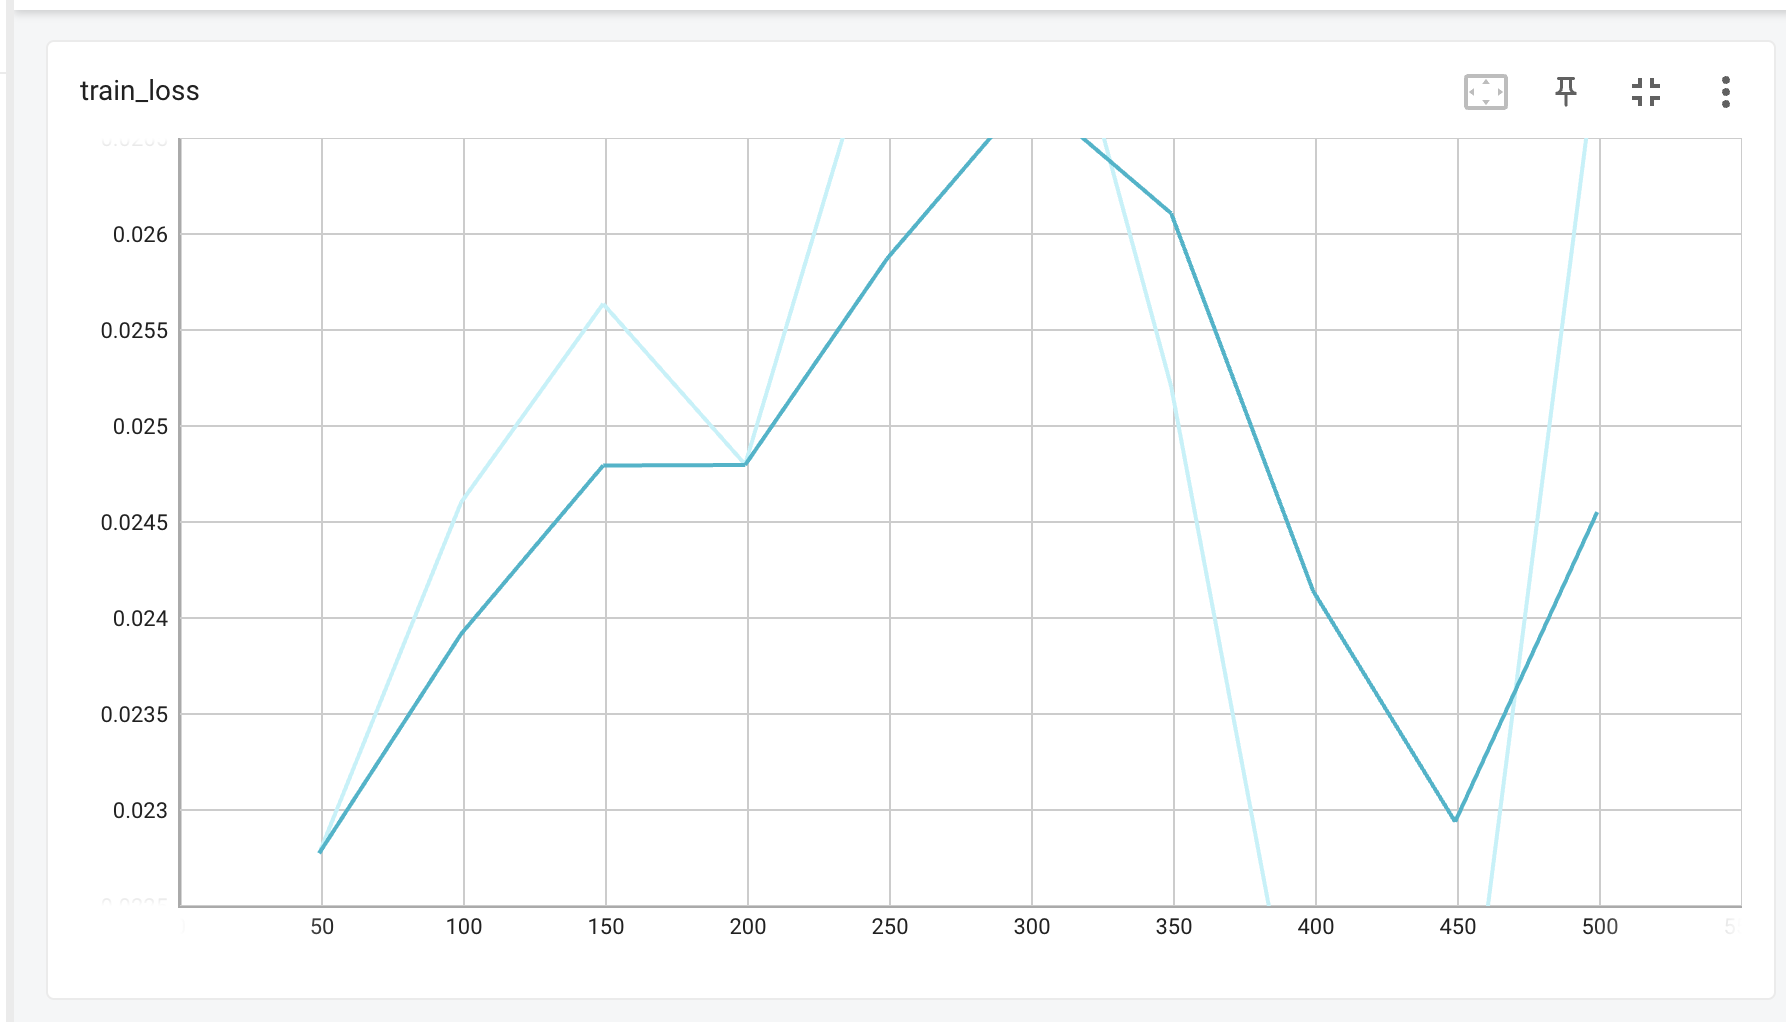

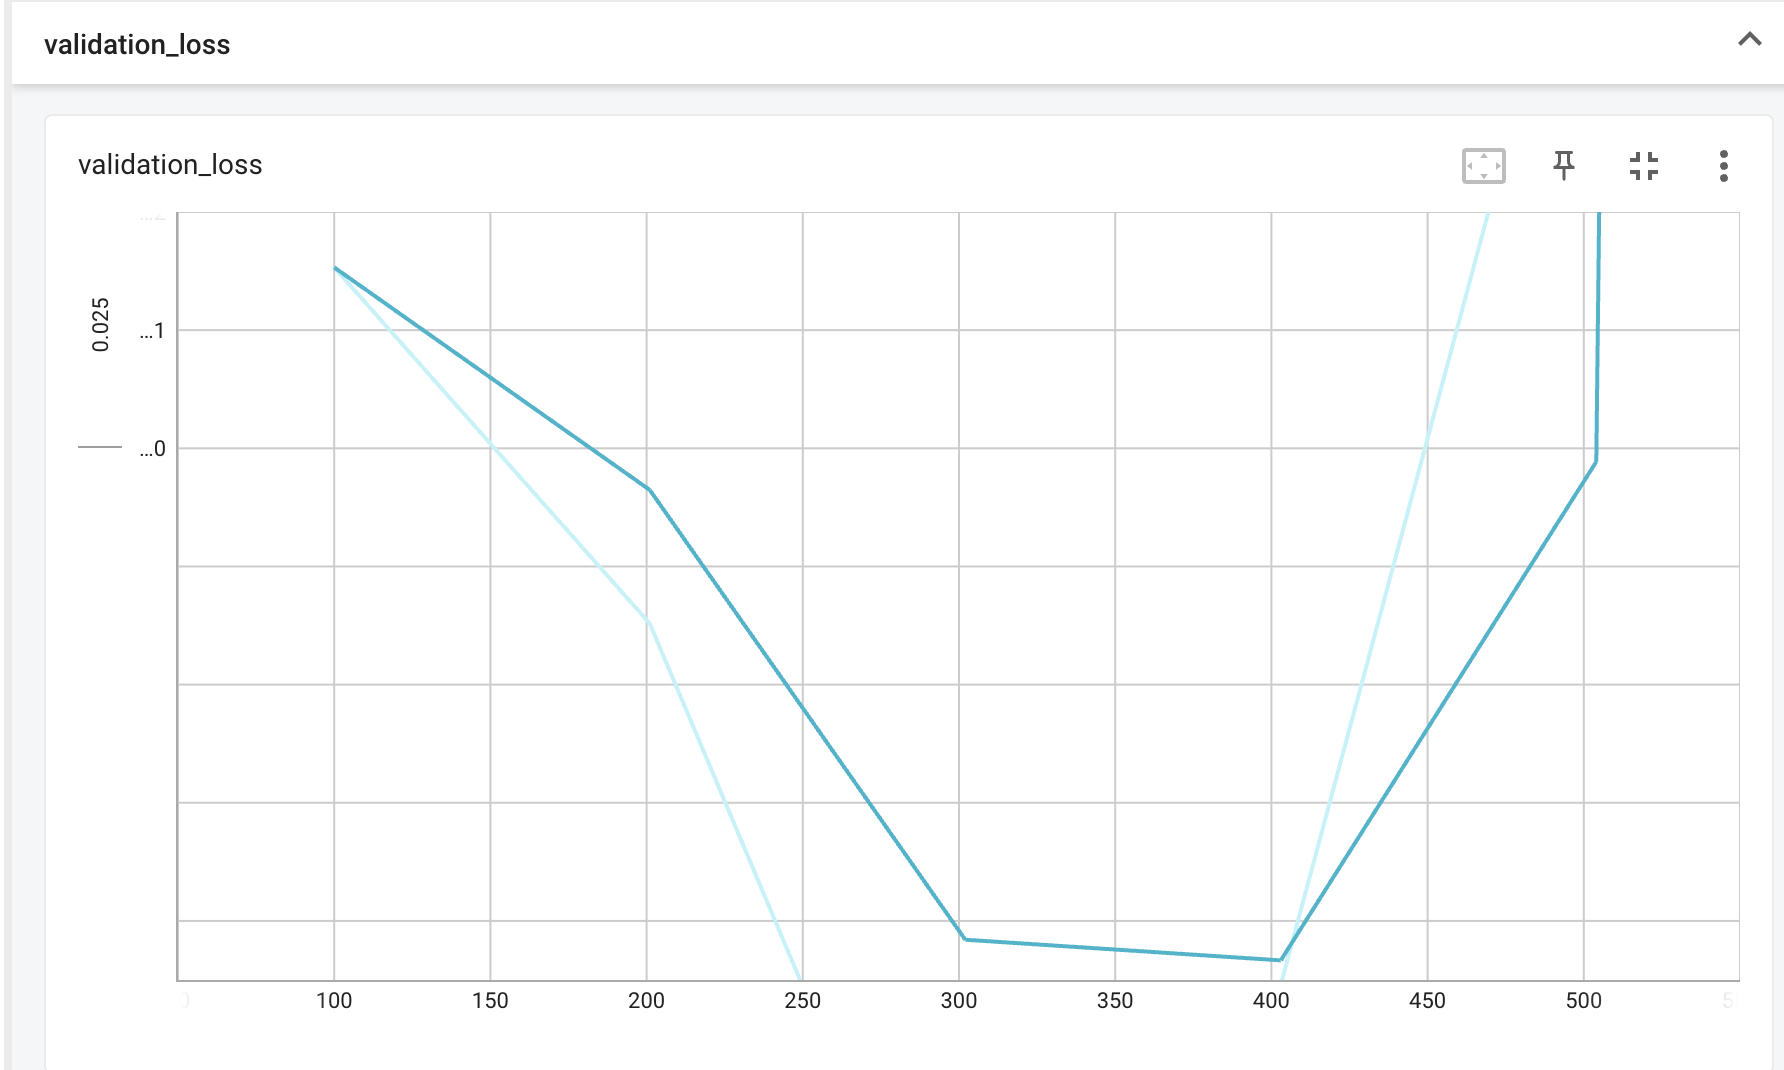

# *Что-ж...Лосс падает и встаёт, он борется...И я борюсь*

In [49]:
import tqdm
import numpy as np
pl_model.eval()
pl_model.to(device)
np.float32

numpy.float32

In [50]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

In [51]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

/tmp/ipykernel_32/3342089651.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(loader):


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [54]:
val_labels

array([ 33.,   7., 152., ..., 182.,  11.,  58.])

In [56]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 14.6 MB/s eta 0:00:0000:0100:01


In [57]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(512)   # build the index
print(index.is_trained)
index.add(train_emb)                  # add vectors to the index
print(index.ntotal)



True
6464


In [58]:
K = 5

In [60]:
Distances, Indexes = index.search(val_emb, K)

In [62]:
# pred_labels[i]  
# k neares emb : train_labels[Indexes[i]] 
#  true_positive_count (max k) 

In [64]:
def precision_at_k(train_labels, pred_labels, Indexes, k):

    precision_per_example = []

    for i in range(len(pred_labels)):
        true_label = train_labels[Indexes[i][0]]
        true_positive_count = np.sum(pred_labels[i] == train_labels[Indexes[i]])
        tp_fp = np.sum(train_labels[Indexes[i]] == true_label) # max k
        precision = true_positive_count / tp_fp
        precision_per_example.append(precision)

    precision = np.mean(precision_per_example)
    return precision


In [65]:
# TP/ (TP + FN) = TP / ([все реальные +1])
def recall_at_k(train_labels, pred_labels, Indexes, k):

    recall_per_example = []
    for i in range(len(pred_labels)):
        true_label = train_labels[Indexes[i][0]]
        true_positive_count = np.sum(pred_labels[i] == train_labels[Indexes[i]])
        recall = true_positive_count / k # k = [все реальные +1]
        recall_per_example.append(recall)
    
    recall = np.mean(recall_per_example)
    return recall


In [69]:
COUNT_CLASS = 196

In [70]:
def mean_average_precision(train_labels, pred_labels, Indexes, k):
    average_precisions = []
    
    for num_class in range(COUNT_CLASS):
        tp = 0
        tp_fp = 0
        for i in range(len(pred_labels)):
            if int(pred_labels[i]) == num_class:
                tp += np.sum(pred_labels[i] == train_labels[Indexes[i]])
                true_label = train_labels[Indexes[i][0]]
                tp_fp += np.sum(train_labels[Indexes[i]] == true_label)
        if tp_fp:
            average_precisions.append(tp / tp_fp)

    mAP = np.mean(average_precisions)
    return mAP



In [71]:
precision_K = precision_at_k(train_labels, val_labels, Indexes, K)
print(f"Precision@{K} = {precision_K}")
recall_K = recall_at_k(train_labels, val_labels, Indexes, K)
print(f"Recall@{K} = {recall_K}")
mAP = mean_average_precision(train_labels, val_labels, Indexes, K)
print(f"mAP = {mAP}")

Precision@5 = 0.03376304481276857
Recall@5 = 0.006752608962553714
mAP = 0.03519812103995777


In [72]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.3 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38244 sha256=2df2f306efdafb2133ea0080014c4e8543d55320497d4e6750bd367e3e096b41
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [73]:
from PIL import Image
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def get_image_from_path(path):
    """A function that gets a path to an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    orig_im = np.array(Image.open(path).convert('RGB'))
    rgb_im = np.array(transform_to_show(orig_im).permute(1,2,0))
    transformed_im = val_transforms(orig_im).unsqueeze(0).to(device)
    orig_im = cv2.resize(orig_im, (512, 512))

    return orig_im, rgb_im, transformed_im

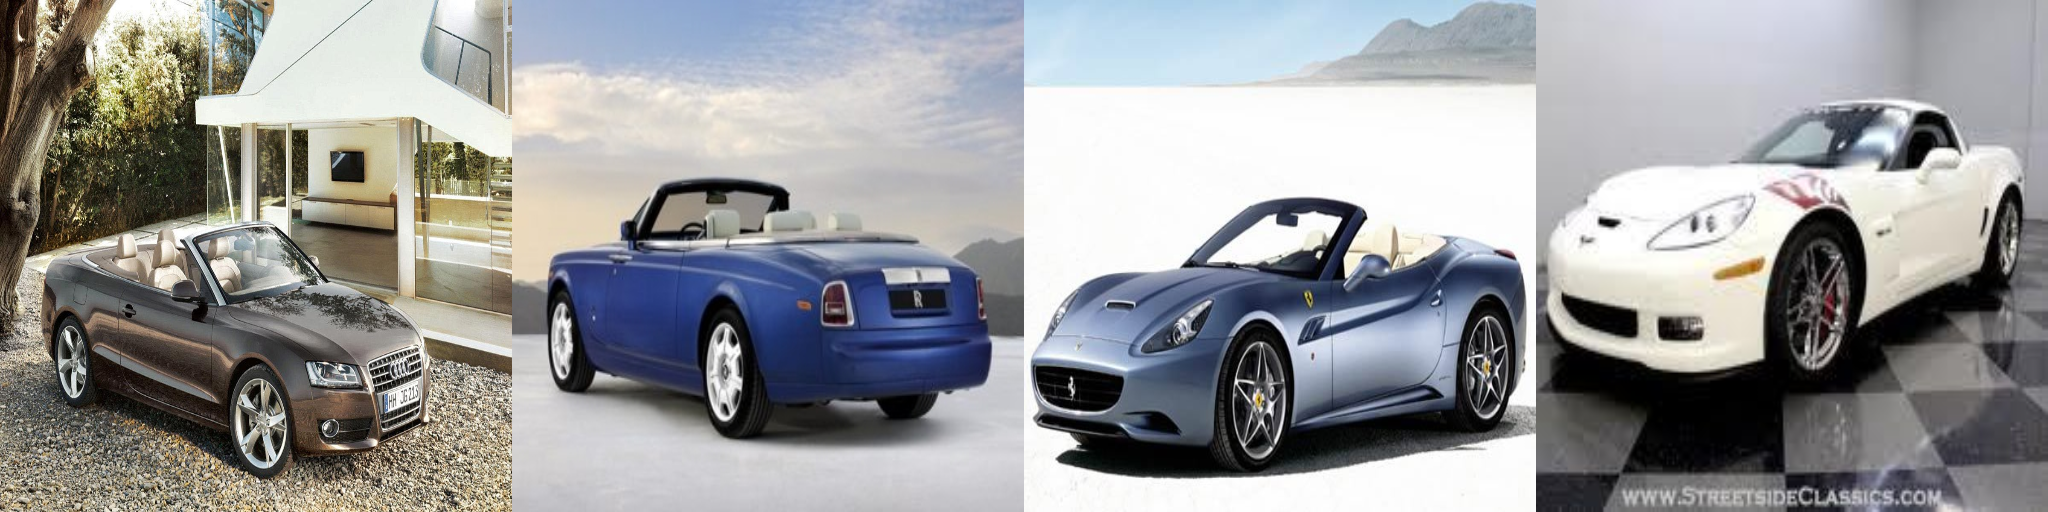

In [140]:
car_img1, car_img_float1, car_tensor1 = get_image_from_path("./cars_train/cars_train/07854.jpg")
car_img2, car_img_float2, car_tensor2 = get_image_from_path("./cars_train/cars_train/07827.jpg")
car_img3, car_img_float3, car_tensor3 = get_image_from_path("./cars_train/cars_train/07829.jpg")
car_img4, car_img_float4, car_tensor4 = get_image_from_path("./cars_train/cars_train/07831.jpg")
Image.fromarray(np.hstack((car_img1, car_img2, car_img3, car_img4)))


# Вроде бы похожие машины)

# будем их матчить к первой

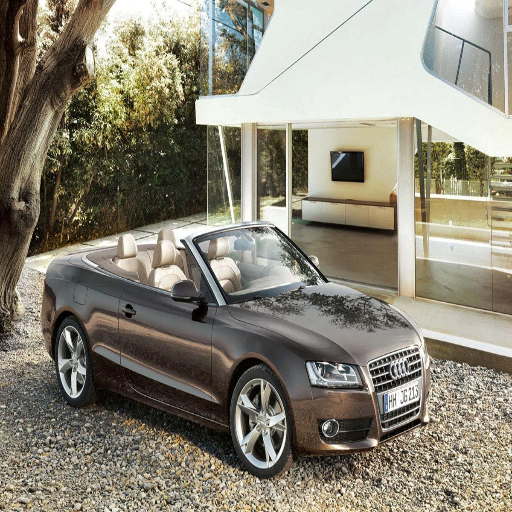

In [143]:
car_img1, car_img_float1, car_tensor1 = get_image_from_path("./cars_train/cars_train/07854.jpg")
car_concept_features = pl_model(car_tensor1)[0, :]
Image.fromarray(car_img1)

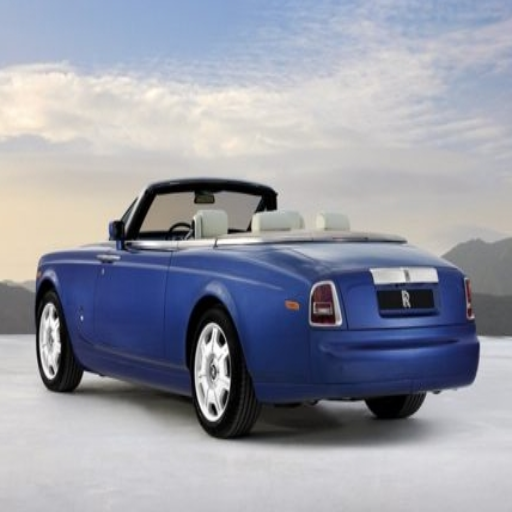

In [142]:
image, image_float, input_tensor = get_image_from_path("./cars_train/cars_train/07827.jpg")
Image.fromarray(image)

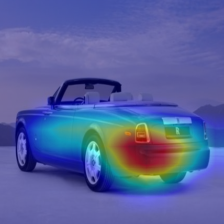

In [144]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
target_layers = [pl_model.model.features[-3]]
car_targets = [SimilarityToConceptTarget(car_concept_features)]


# Where is the car in the image
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

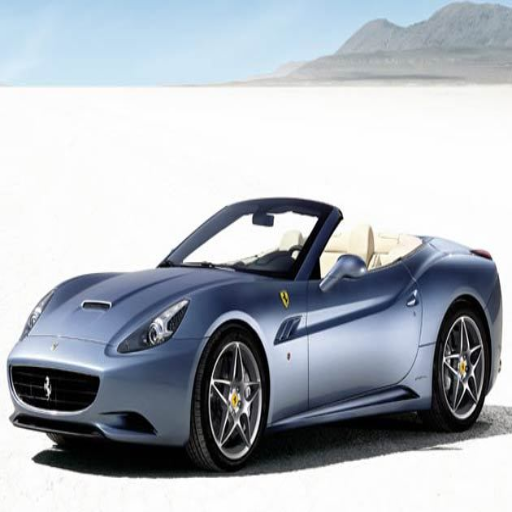

In [145]:
image, image_float, input_tensor = get_image_from_path("./cars_train/cars_train/07829.jpg")
Image.fromarray(image)

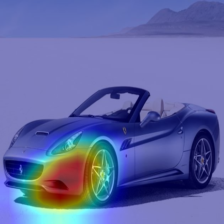

In [146]:
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

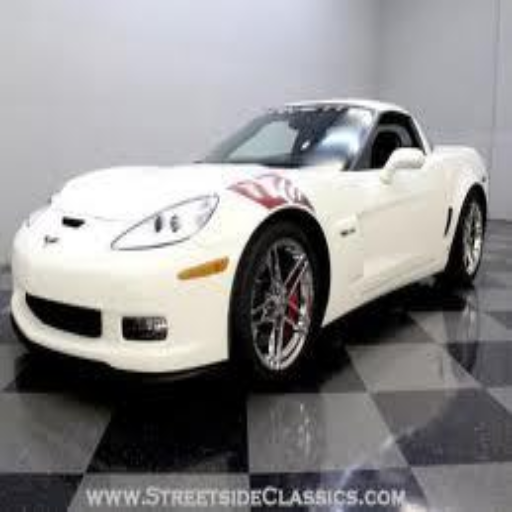

In [147]:
image, image_float, input_tensor = get_image_from_path("./cars_train/cars_train/07831.jpg")
Image.fromarray(image)


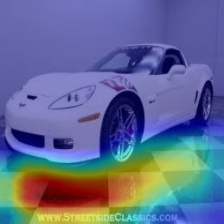

In [148]:
with GradCAM(model=pl_model.model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

Наверное он бы должен бы смотреть на стекло...


**За 5 эпох AlexNet не смог ничего выучить, ждал больше часа, больше ждать лайтинг мне не дал(**